#### Getting Started with FashionMNIST

This notebook shows how to load the FashionMNIST dataset in PyTorch and illustrates what kind of samples it contains.

In [1]:
import torch
import random
import numpy as np
import matplotlib.pyplot as plt
from torchvision.datasets import FashionMNIST
from torchvision.transforms import ToTensor
from torch.utils.data import ConcatDataset
import torchvision.transforms as transforms

In [2]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Transformationen definieren
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))  # Normalisiert Daten auf [-1, 1]
])

# Erstellen Sie eine Instanz des Trainingssplits des FashionMNIST-Datasets
dataset_train = FashionMNIST(root='/data/FashionMNIST', train=True, download=True, 
                             transform=transform, target_transform=lambda x: torch.Tensor([x]).int())

# Jetzt erstellen Sie eine Instanz des Testsplits
dataset_valid = FashionMNIST(root='/data/FashionMNIST', train=False, download=True, 
                             transform=transform, target_transform=lambda x: torch.Tensor([x]).int())

# Für unsere Zwecke können wir die 60k Training- und 10k Testbeispiele kombinieren
from torch.utils.data import ConcatDataset
dataset = ConcatDataset([dataset_train, dataset_valid])

# Einige Informationen zum Datensatz anzeigen
print(f'The combined dataset contains {len(dataset)} samples.')
print(f'It contains objects from the following {len(dataset_train.classes)} classes:')
print(dataset_train.classes, '\n')
# select a random sample index and load the corresponding data sample
sample_idx = random.randrange(len(dataset))
# 
img_tensor, class_label = dataset.__getitem__(sample_idx)
trainloader = torch.utils.data.DataLoader(dataset_train, batch_size=2048,
                                          shuffle=True, num_workers=2)

print('The shape of an image tensor is:', img_tensor.shape)
print('The shape of a class label is:', class_label.shape)

The combined dataset contains 70000 samples.
It contains objects from the following 10 classes:
['T-shirt/top', 'Trouser', 'Pullover', 'Dress', 'Coat', 'Sandal', 'Shirt', 'Sneaker', 'Bag', 'Ankle boot'] 

The shape of an image tensor is: torch.Size([1, 28, 28])
The shape of a class label is: torch.Size([1])


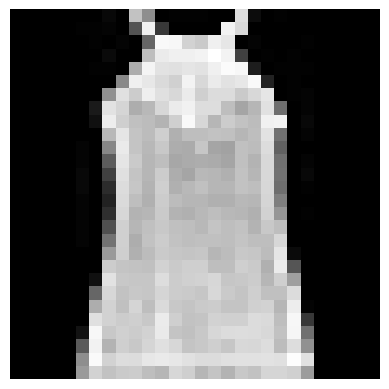

The image shows an instance of Shirt.


In [3]:
# we can also visualize and describe a sample
fig, ax = plt.subplots()
ax.imshow(img_tensor.cpu().squeeze(), cmap='Greys_r')
plt.axis('off')
plt.show()
print('The image shows an instance of ' + dataset_train.classes[class_label.item()] + '.')

In [4]:
min_value = torch.min(img_tensor)
max_value = torch.max(img_tensor)

print(f"Minimaler Wert: {min_value.item()}")
print(f"Maximaler Wert: {max_value.item()}")



Minimaler Wert: -1.0
Maximaler Wert: 1.0


In [5]:
# handvoll resisdual basic blocks -> flatten -> handvoll fully conntected layers
# resnet basic block : conv3x3 + norm_layer + non_lin + conv3x3 + normlayer
# identity: conv1x1 + norm layer
# output: non_lin(identity_layers(x) + [conv3x3 + norm_layer + non_lin + conv3x3 + normlayer](x))

In [6]:
def create_linear_schedule(steps, start, end):
    step_size = (end - start) / (steps - 1)  
    linear_schedule = []
    for i in range(steps):
        linear_schedule.append(start + i * step_size)
    return linear_schedule



In [7]:
def normalize_image(image):
    min_value = torch.min(image)
    max_value = torch.max(image)
    
    normalized_image = 2 * ((image - min_value) / (max_value - min_value)) - 1
    return normalized_image

In [8]:
# Function to add Gaussian noise to an image tensor
def add_gaussian_noise(image, mean=0., std=1.):
    noise = torch.empty_like(image).normal_(mean=0,std=1) * std + mean
    # beta*eps + sqrt(1-beta)*image+std # (1-beta).sqrt()*image + beta*eps
    # Clip the values to be between 0 and 1
    # noisy_image = normalize_image(noisy_image)
    return noise

In [9]:
def one_forward_step(curr_image, beta):
    std = np.sqrt(beta) #* np.random.normal()#* np.identity(like=curr_image) Nicht notwendig da äquivalent zu Skalar von Rechts
    mean = np.sqrt(1-beta) * curr_image #+ std
    return add_gaussian_noise(curr_image,mean=mean,std=std)

In [16]:
def mache_noise(image, anzahl_bilder):
    # Convert the image to a PyTorch tensor
    # transform = transforms.ToTensor()
    # image_tensor = transform(image)
    
    # Display the original image
    plt.imshow(image.cpu().squeeze())
    plt.title("Original Image")
    plt.show()
    
    verrauschte_bilder = []
    schedule = create_linear_schedule(anzahl_bilder, 0.0001, 0.02)
    print(schedule)
    noisy_image_tensor = image
    for i in range(len(schedule)):
        noisy_image_tensor = one_forward_step(noisy_image_tensor, schedule[i])
        
        # Convert the noisy image tensor back to a PIL image
        noisy_image = ((noisy_image_tensor/2)+0.5).cpu().squeeze()
        
        verrauschte_bilder.append(noisy_image)
        
        # Optional: Display each noisy image if desired
        plt.imshow(noisy_image, cmap='Greys_r')
        plt.title(f"Noisy Image {i+1}: {noisy_image_tensor.mean()}, {noisy_image_tensor.std()}")
        plt.show()
    

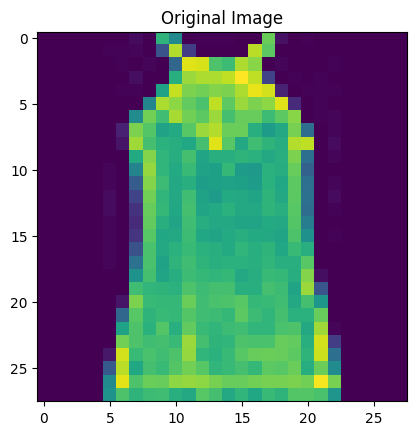

[0.0001, 0.00030101010101010105, 0.000502020202020202, 0.0007030303030303031, 0.0009040404040404042, 0.001105050505050505, 0.0013060606060606062, 0.0015070707070707072, 0.0017080808080808083, 0.0019090909090909093, 0.00211010101010101, 0.002311111111111111, 0.002512121212121212, 0.002713131313131313, 0.002914141414141414, 0.0031151515151515152, 0.0033161616161616163, 0.0035171717171717173, 0.0037181818181818184, 0.0039191919191919194, 0.0041202020202020205, 0.0043212121212121216, 0.004522222222222223, 0.004723232323232324, 0.004924242424242425, 0.005125252525252526, 0.005326262626262627, 0.005527272727272728, 0.005728282828282829, 0.00592929292929293, 0.006130303030303031, 0.006331313131313132, 0.006532323232323233, 0.006733333333333334, 0.006934343434343435, 0.007135353535353536, 0.007336363636363637, 0.0075373737373737384, 0.0077383838383838395, 0.007939393939393939, 0.00814040404040404, 0.008341414141414141, 0.008542424242424242, 0.008743434343434343, 0.008944444444444444, 0.0091454

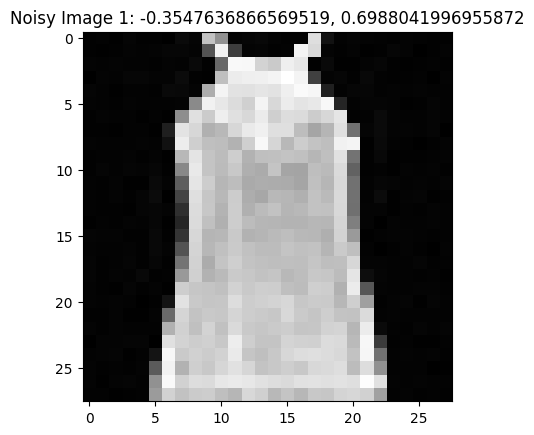

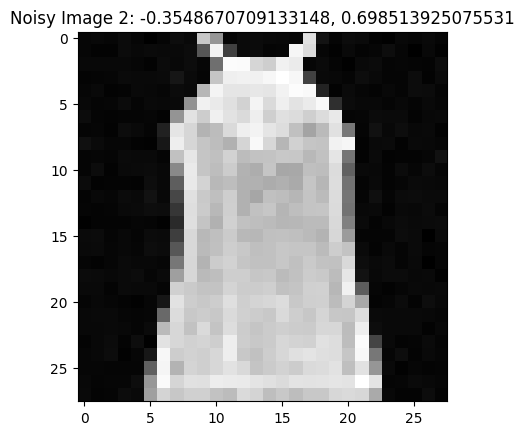

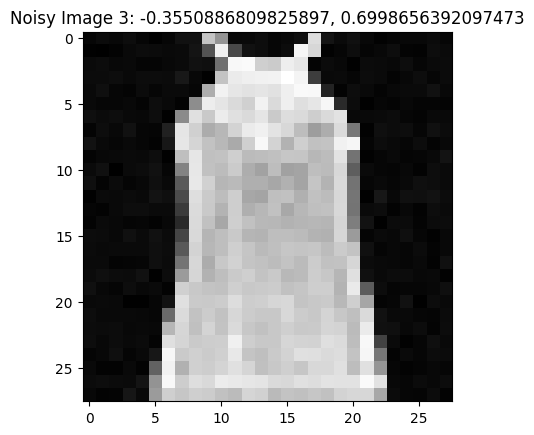

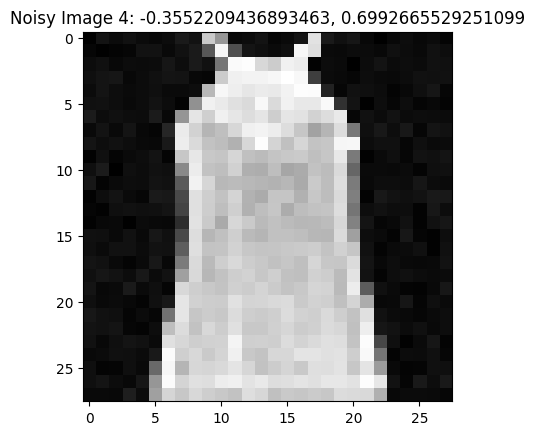

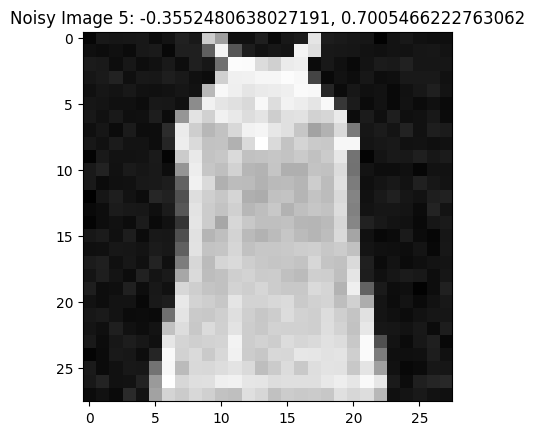

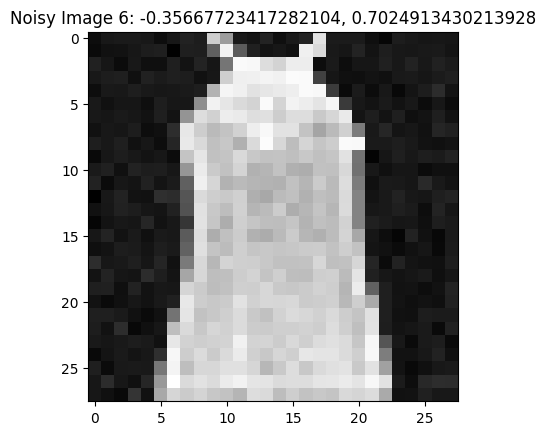

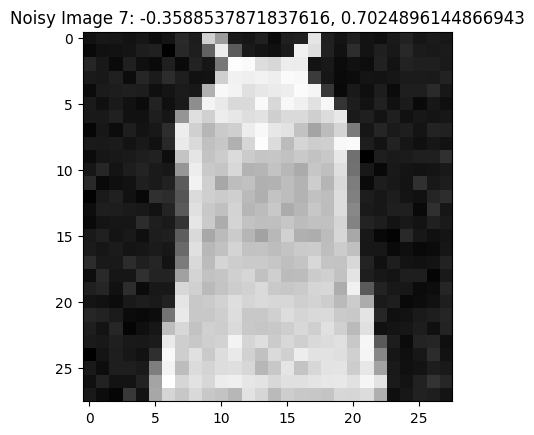

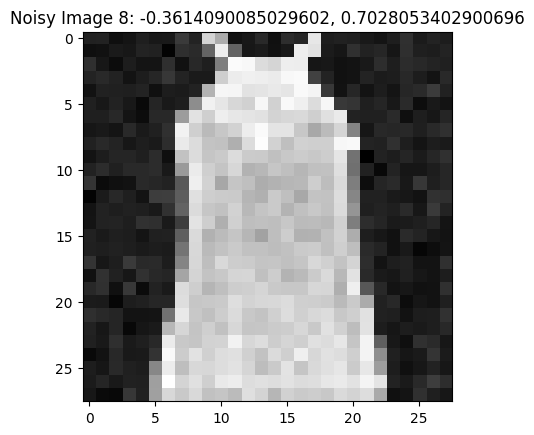

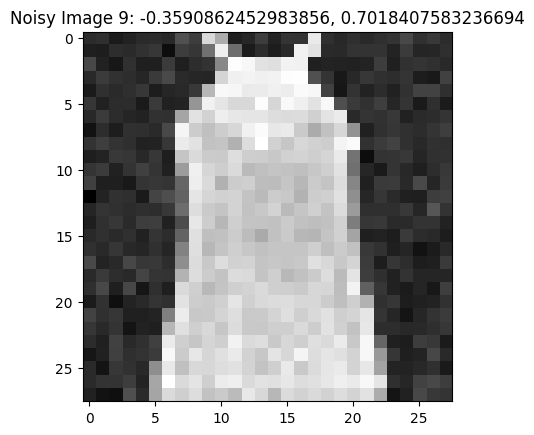

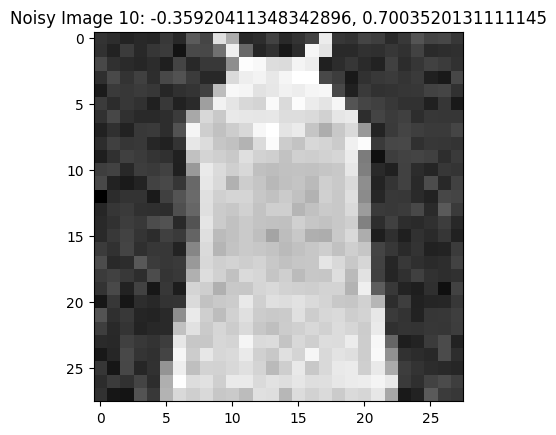

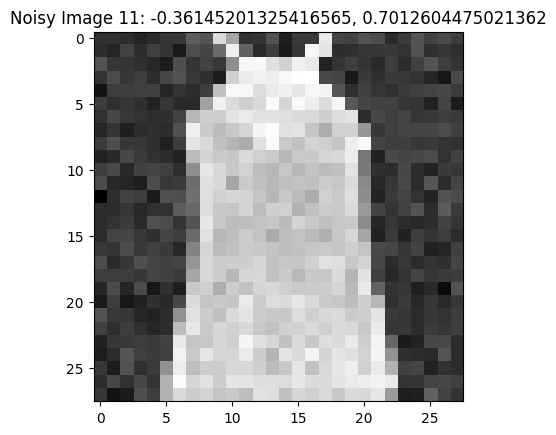

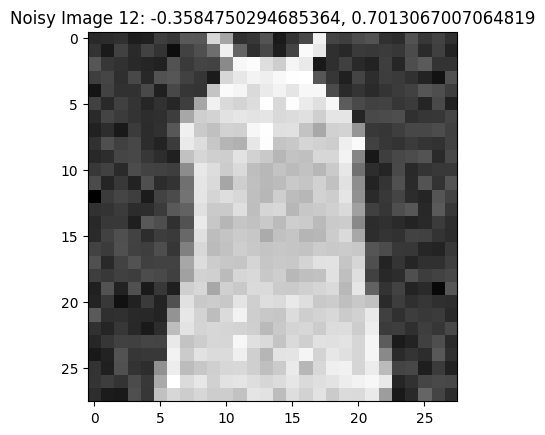

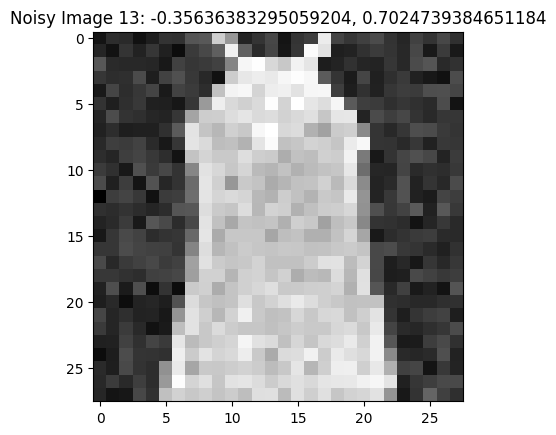

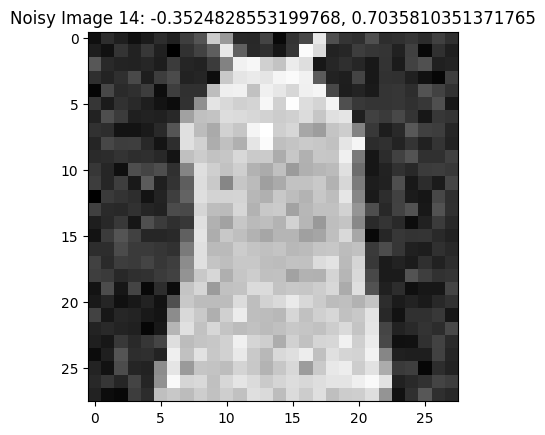

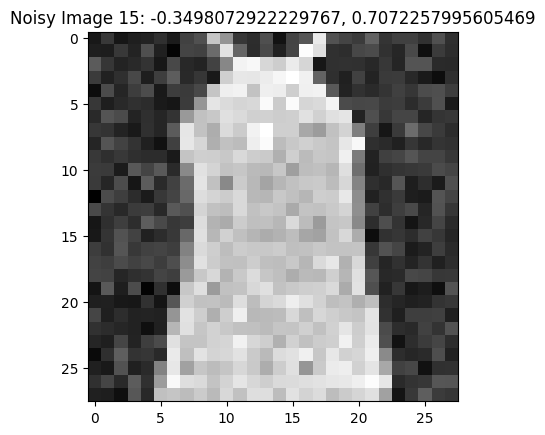

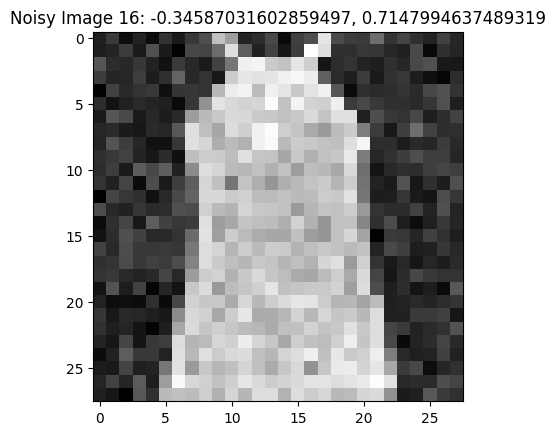

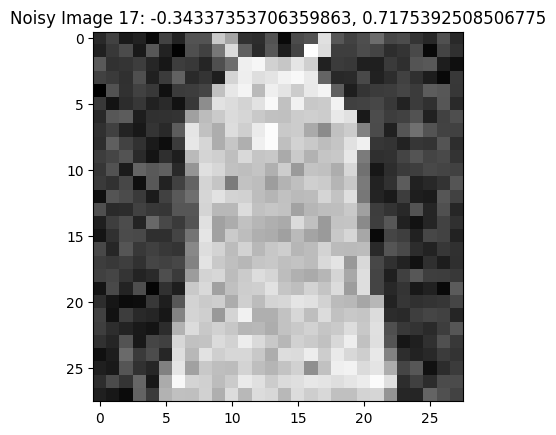

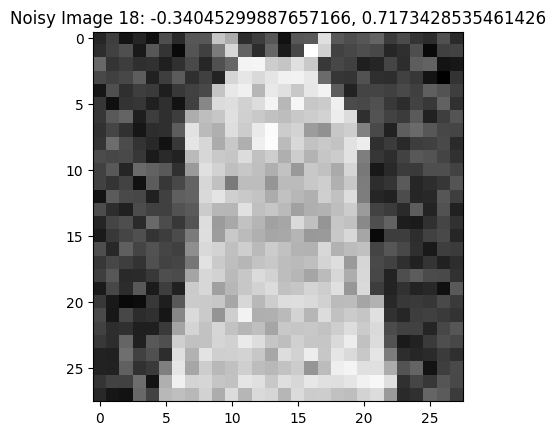

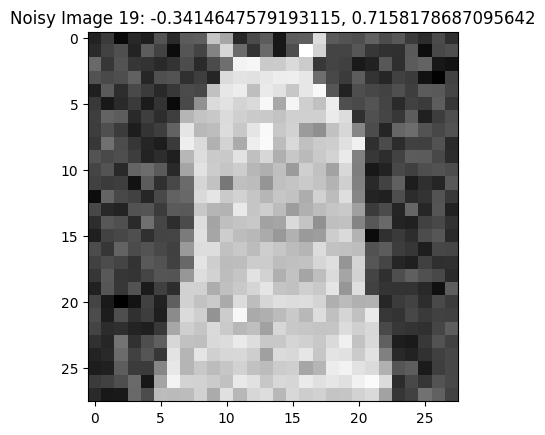

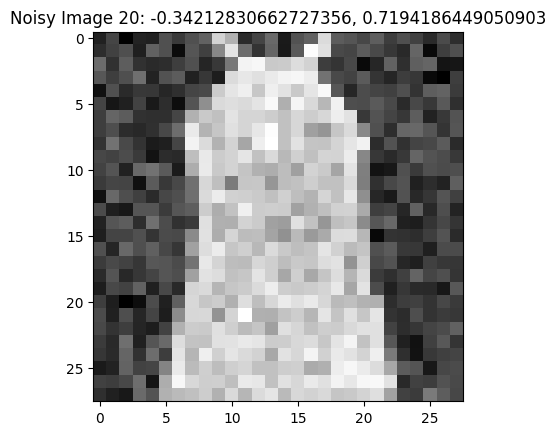

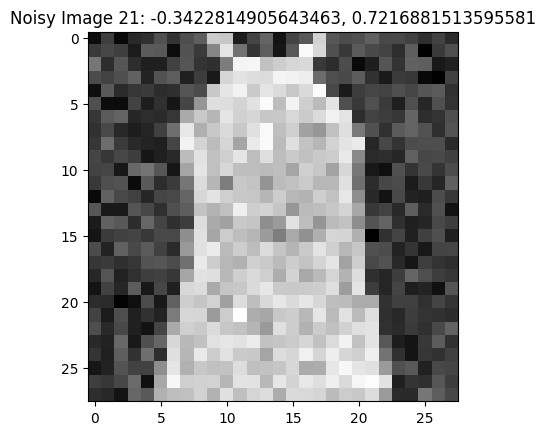

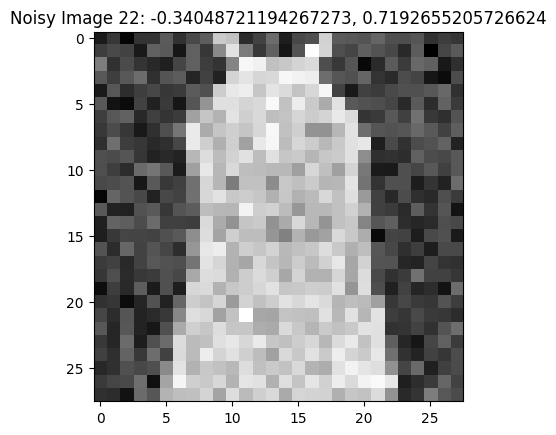

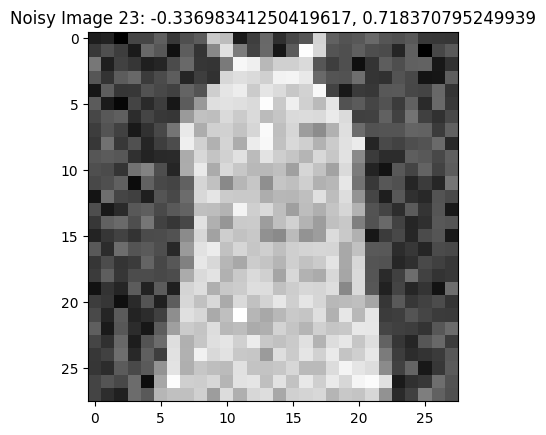

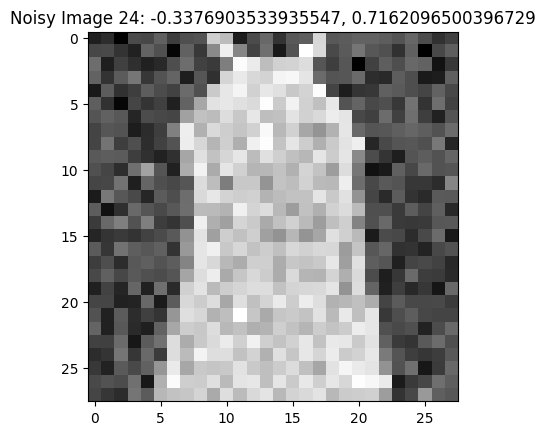

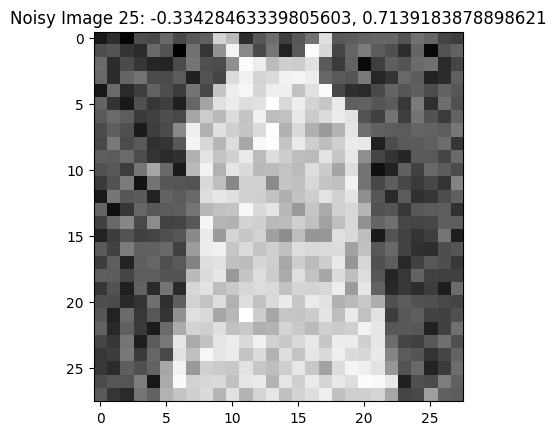

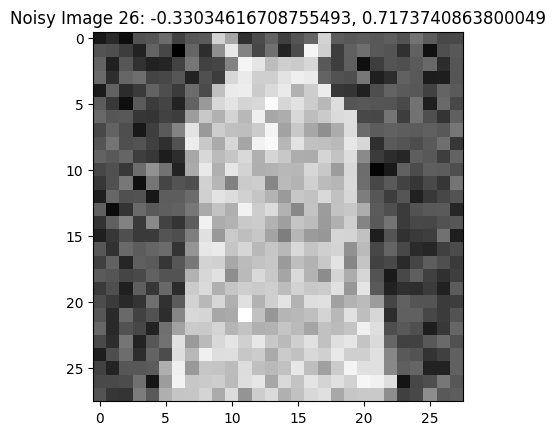

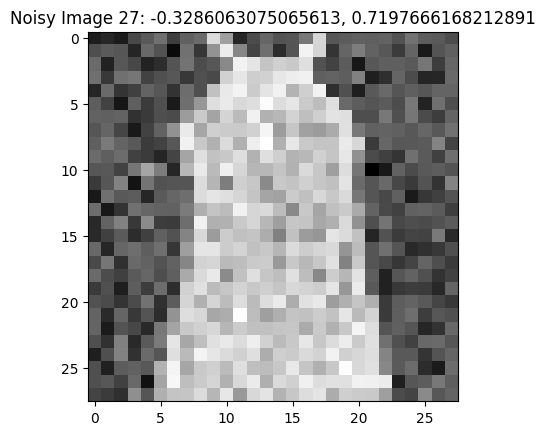

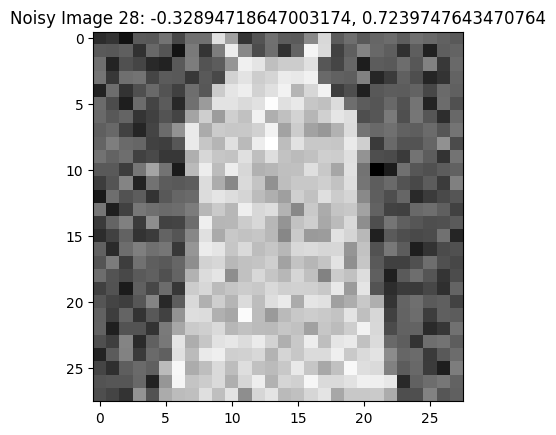

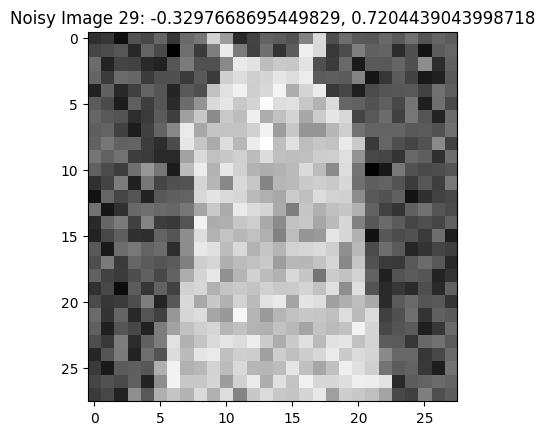

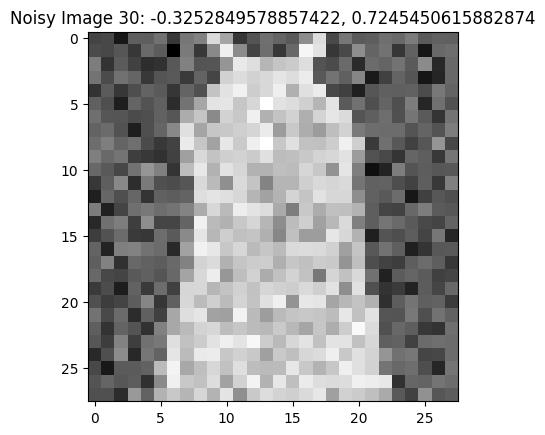

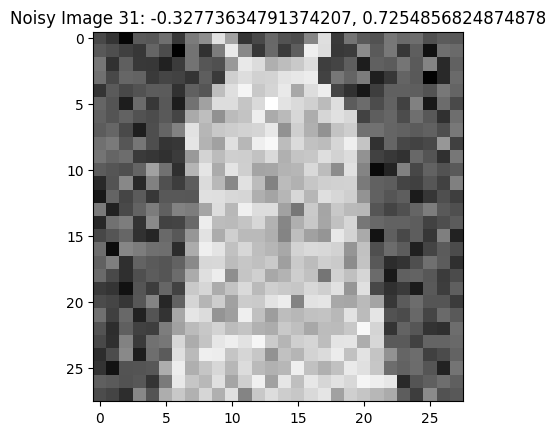

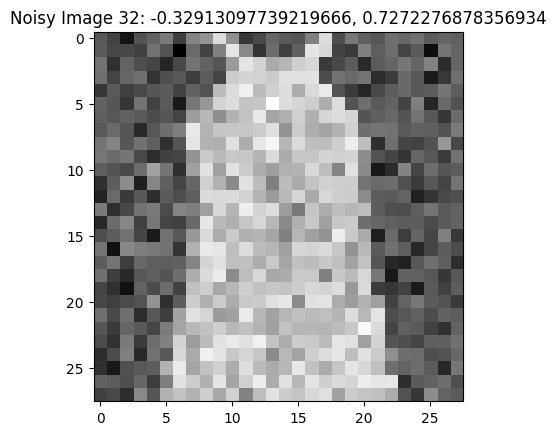

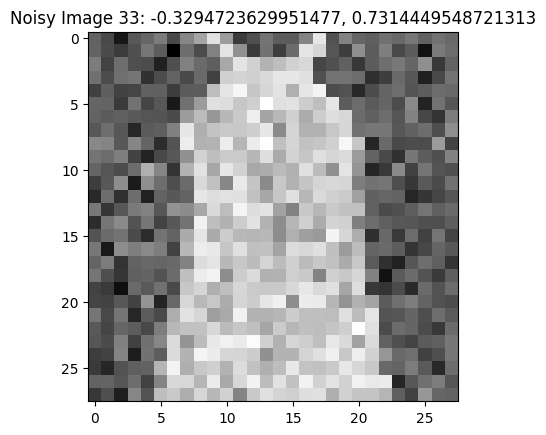

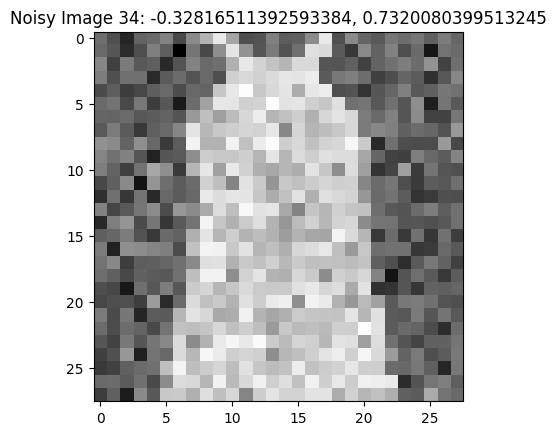

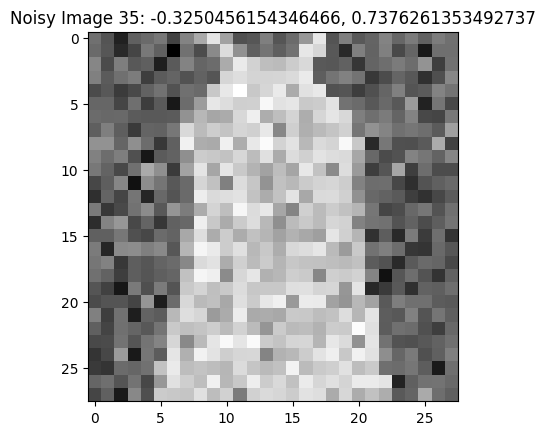

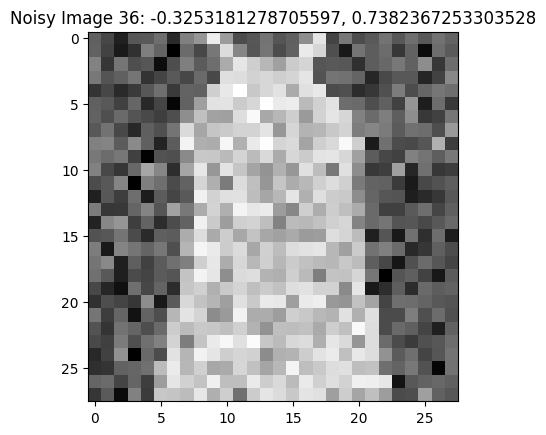

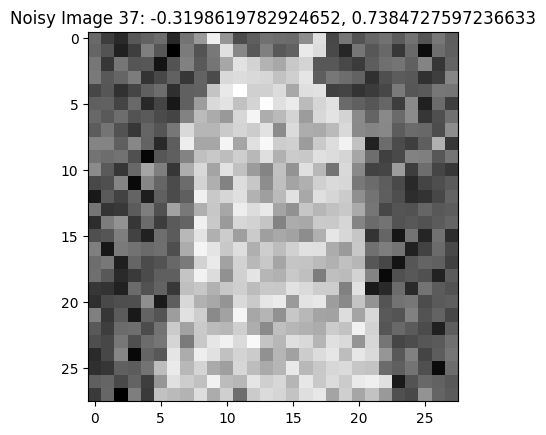

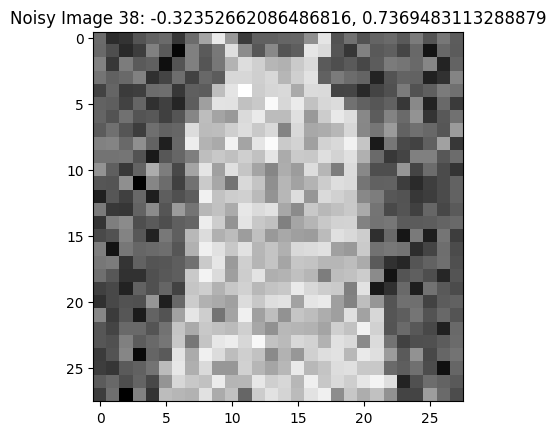

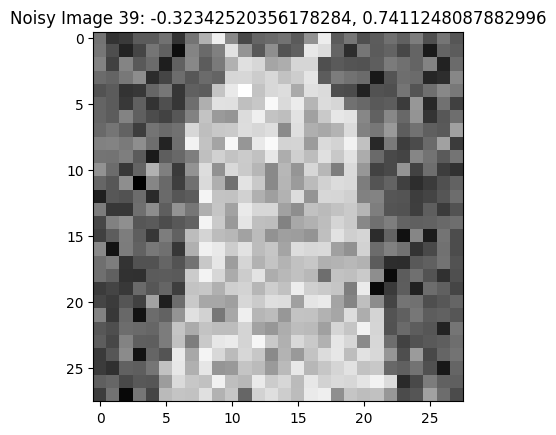

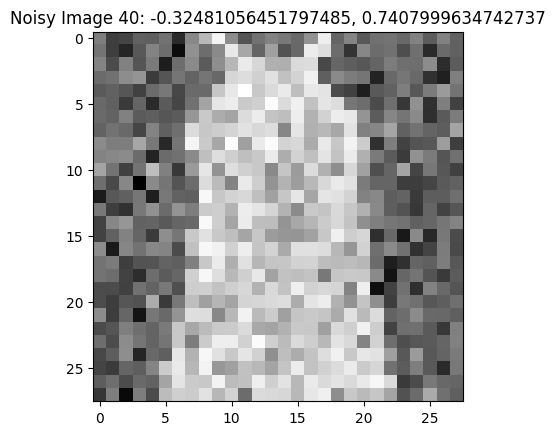

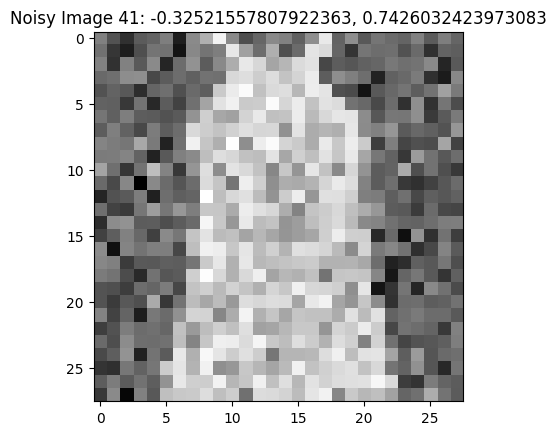

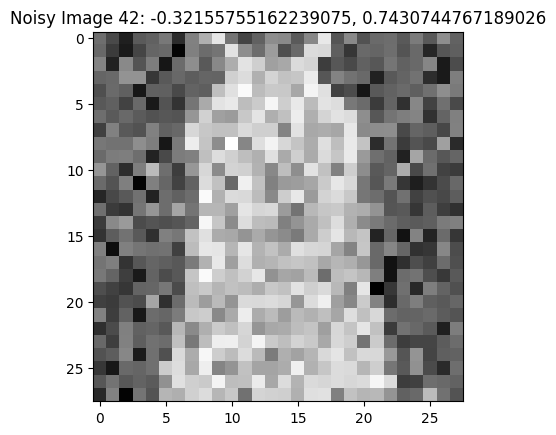

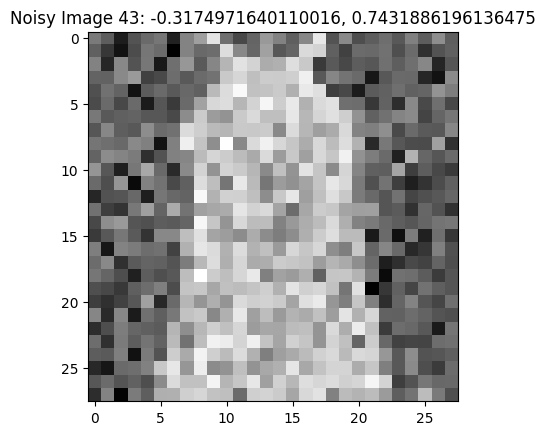

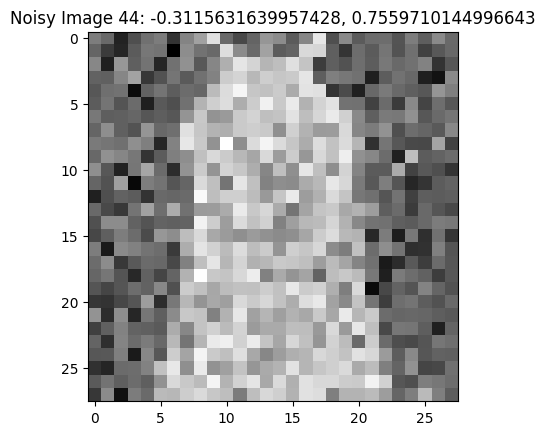

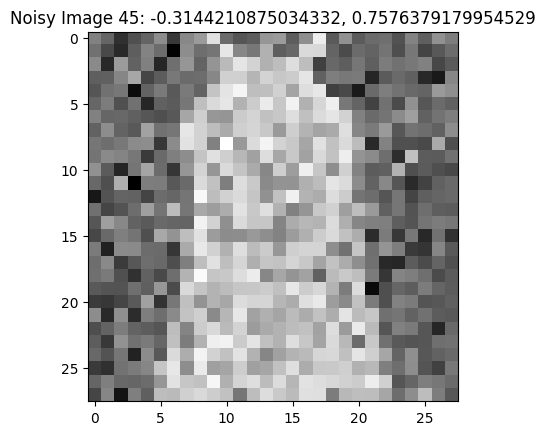

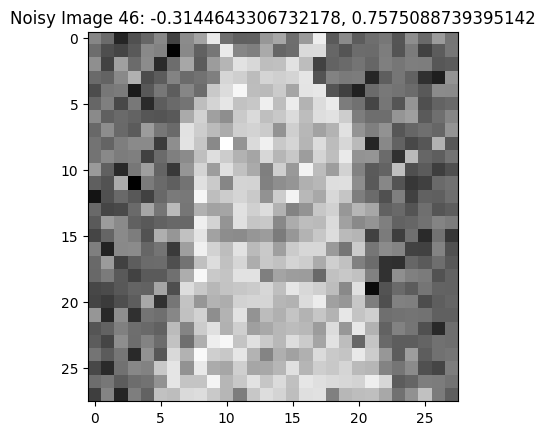

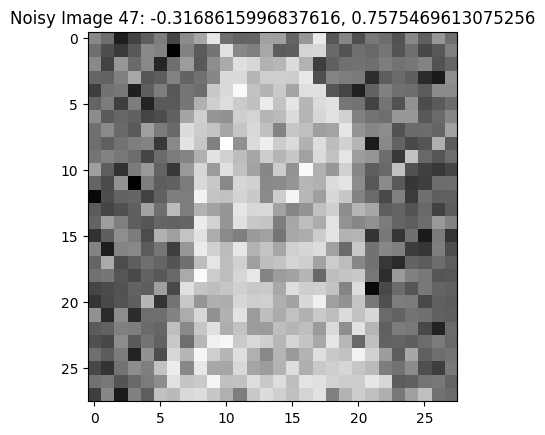

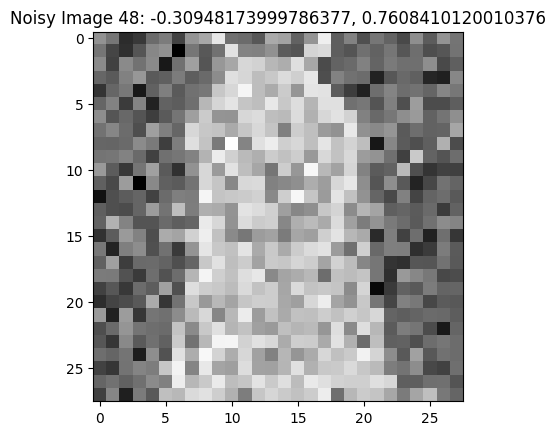

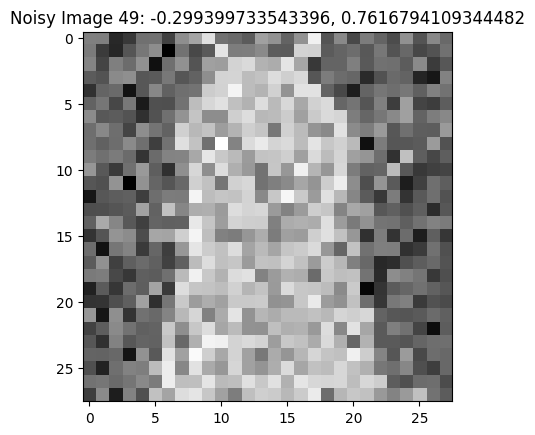

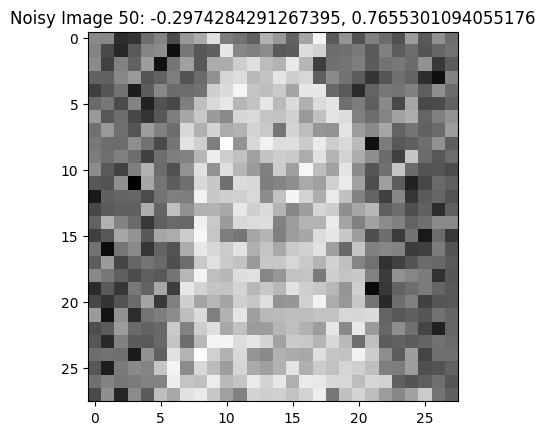

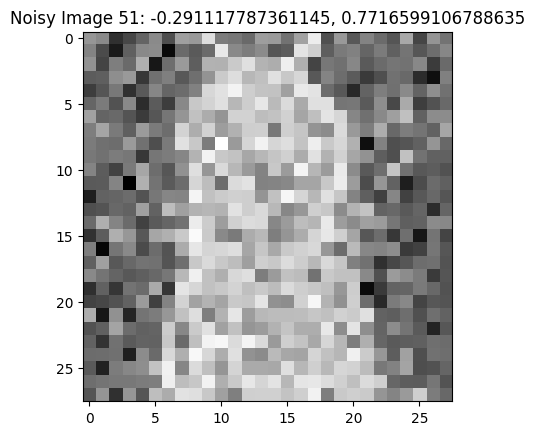

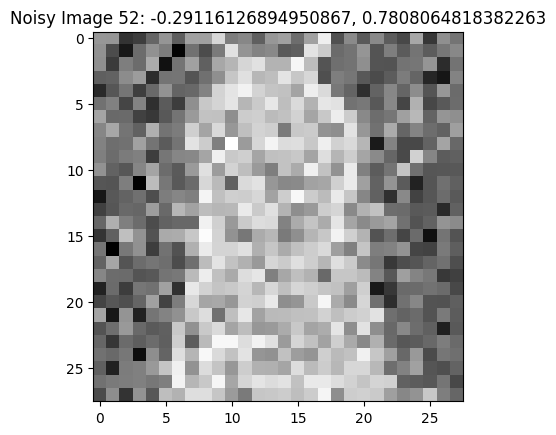

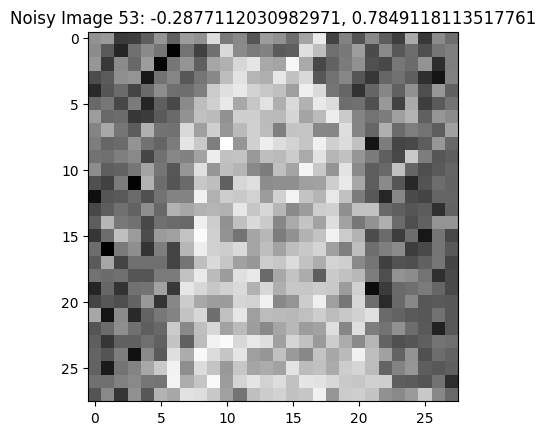

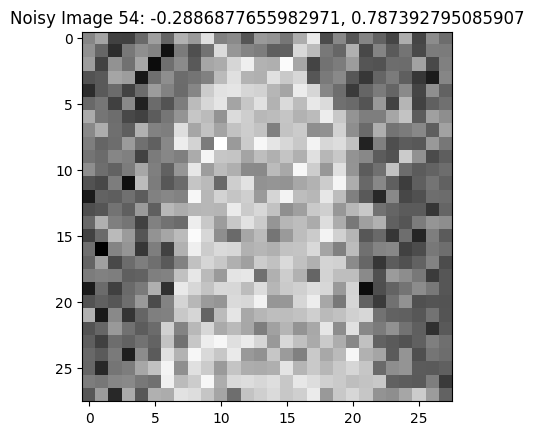

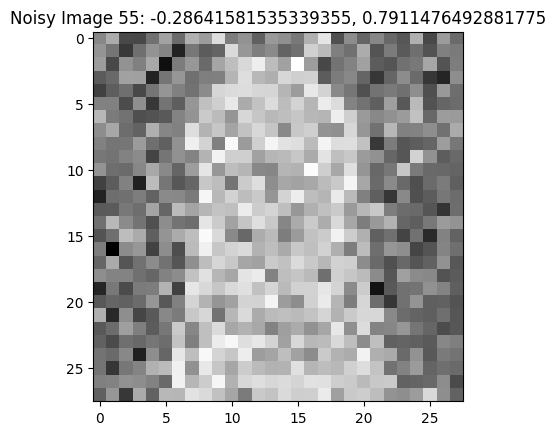

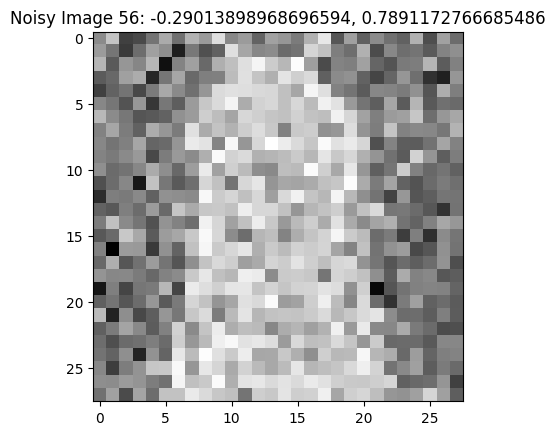

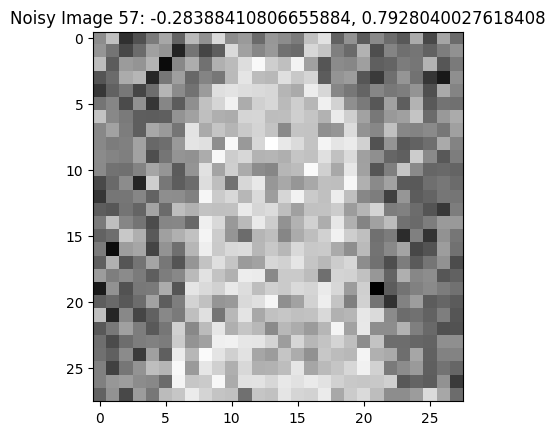

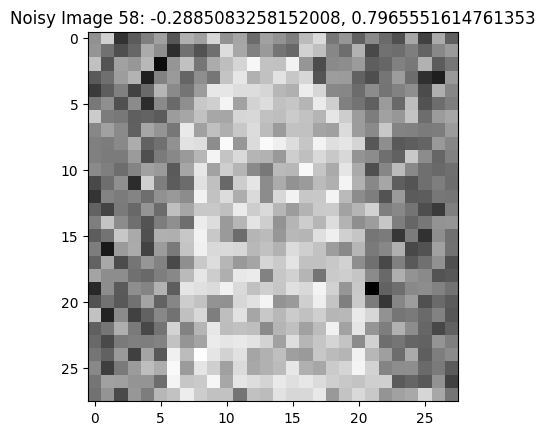

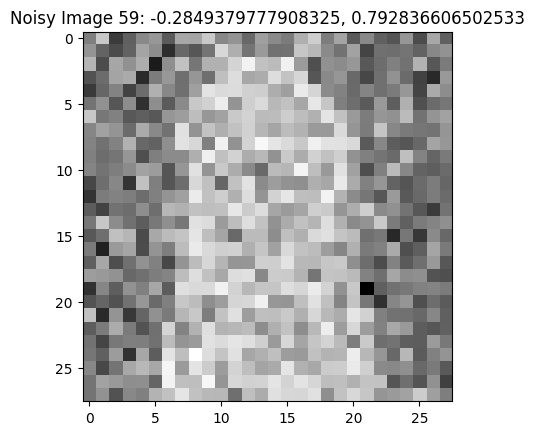

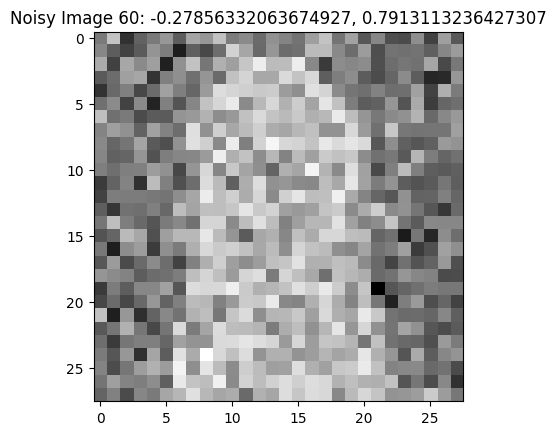

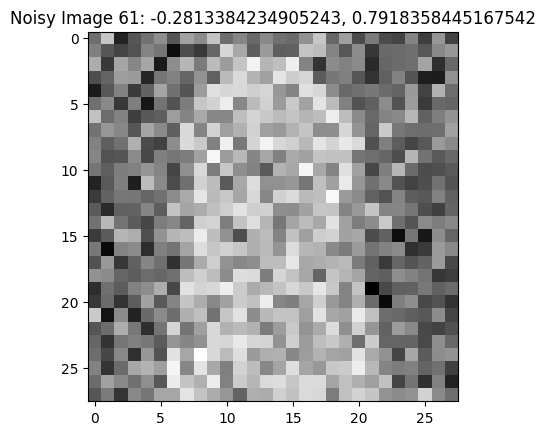

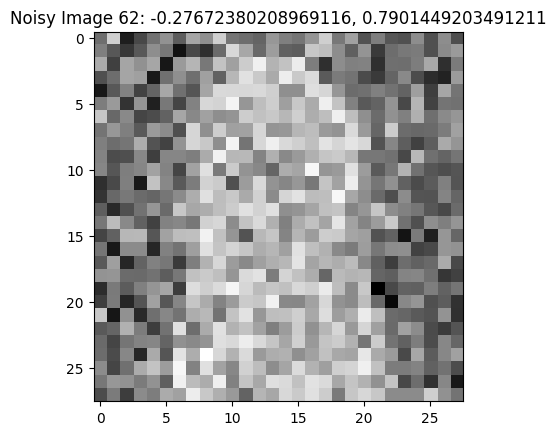

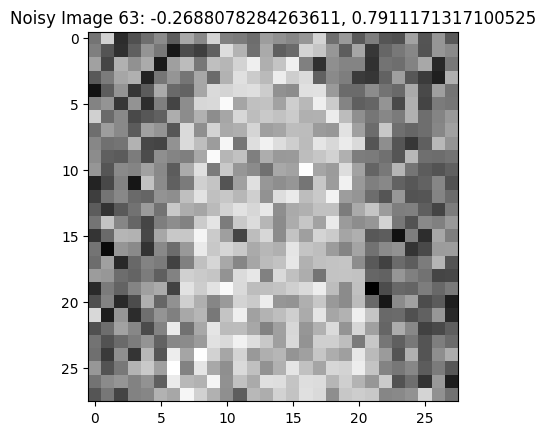

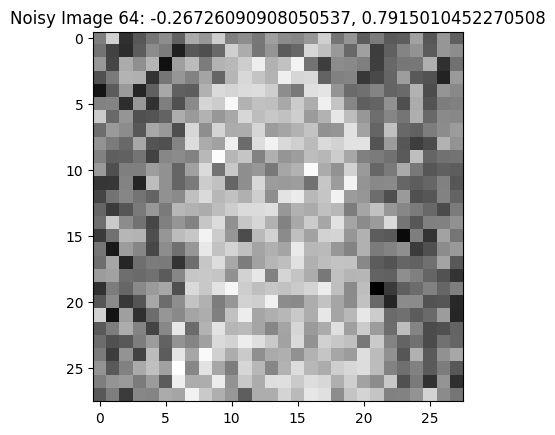

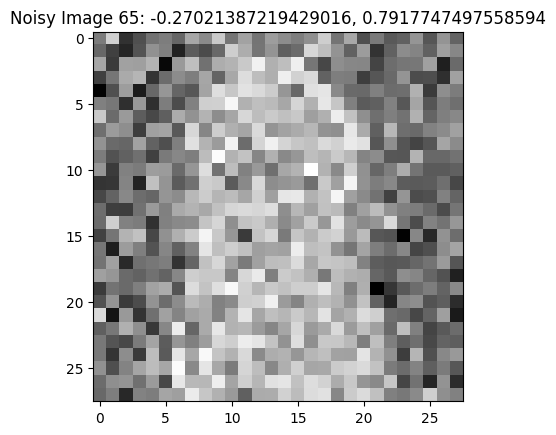

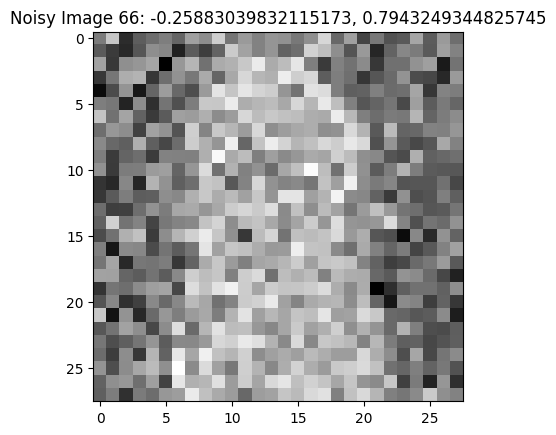

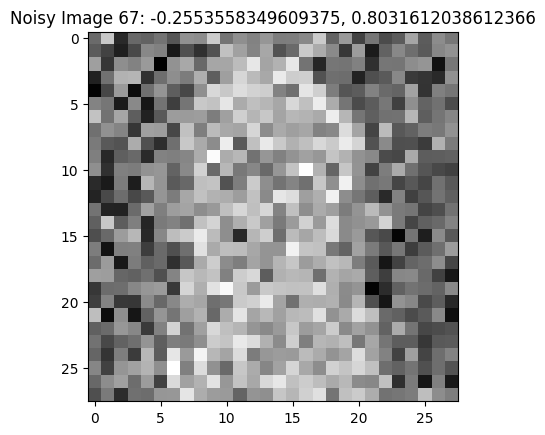

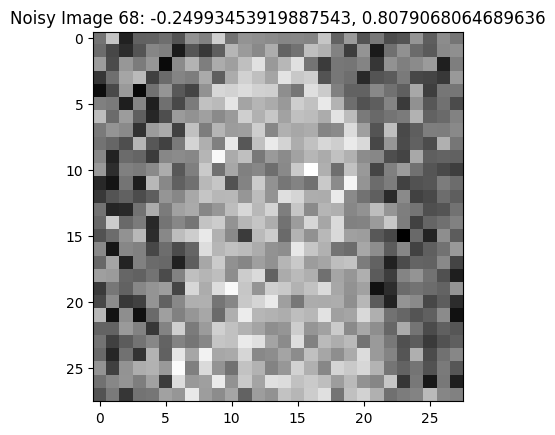

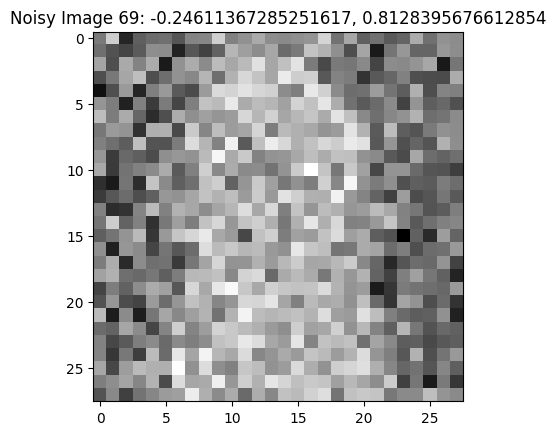

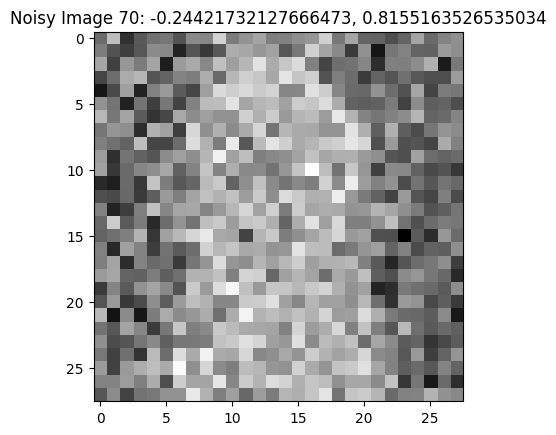

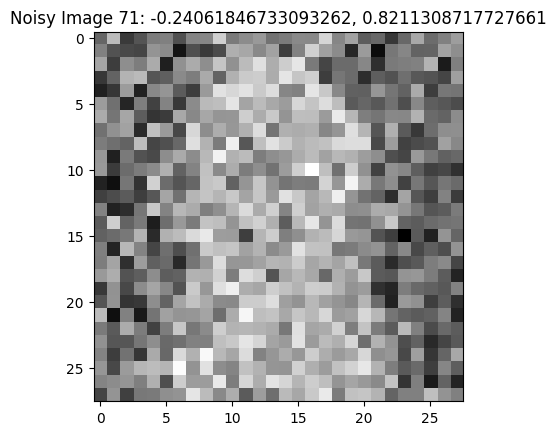

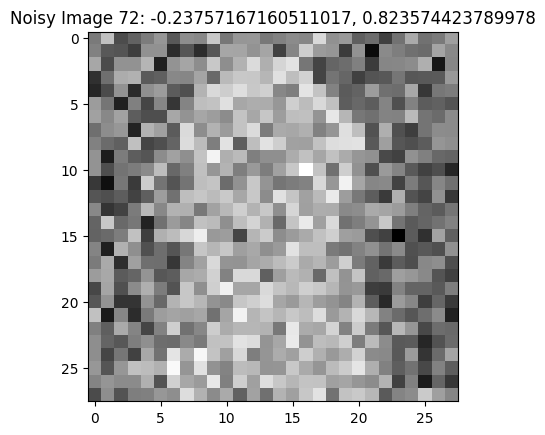

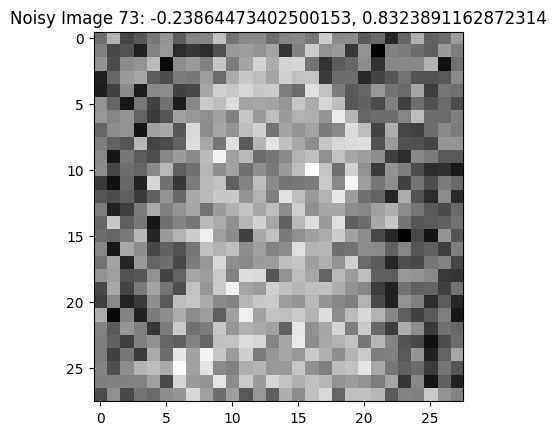

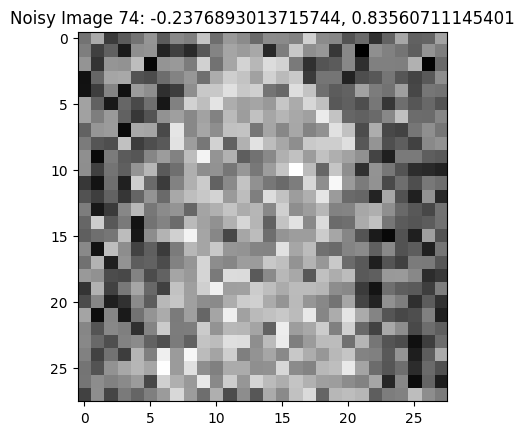

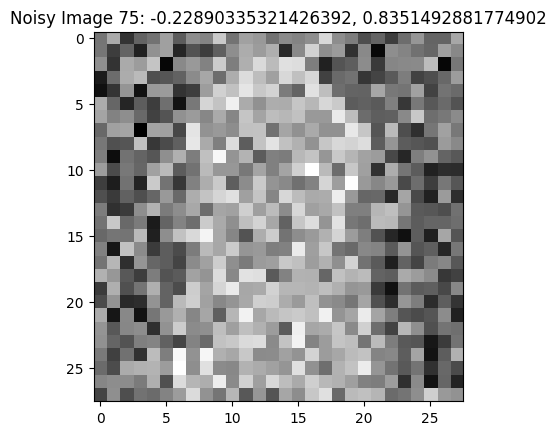

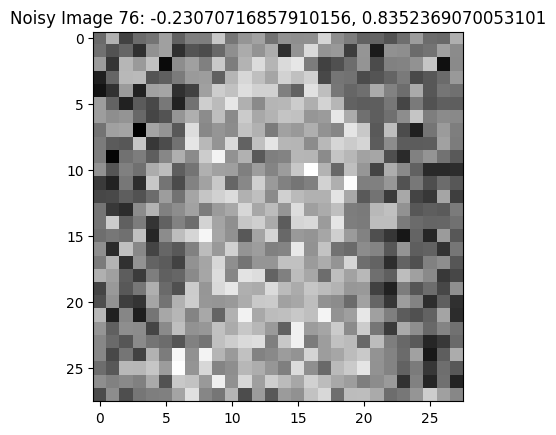

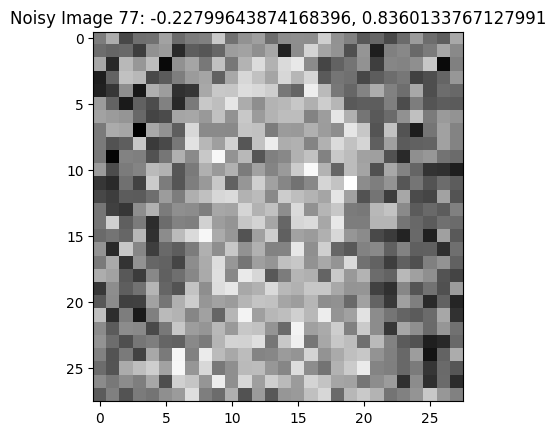

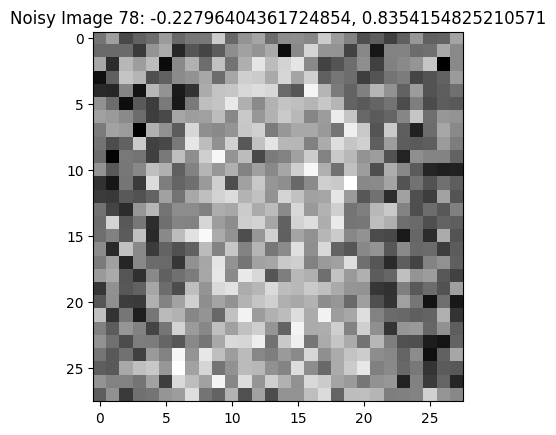

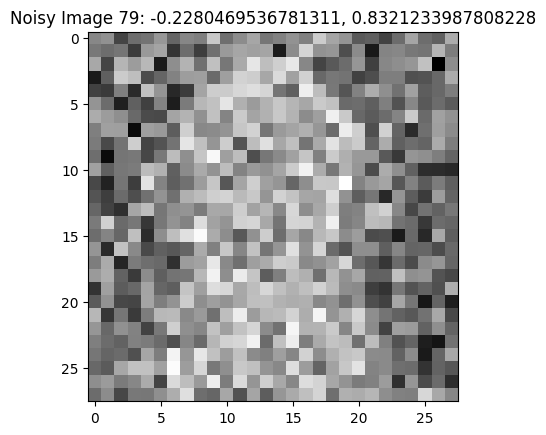

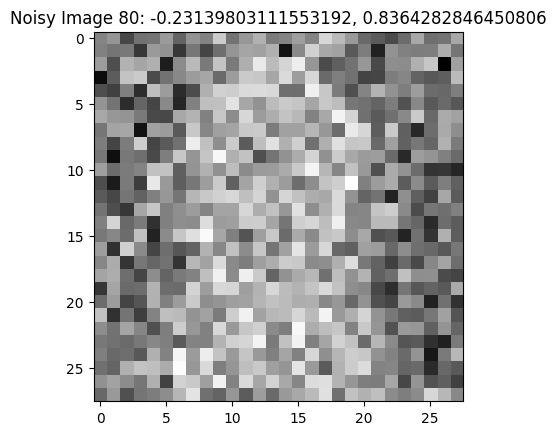

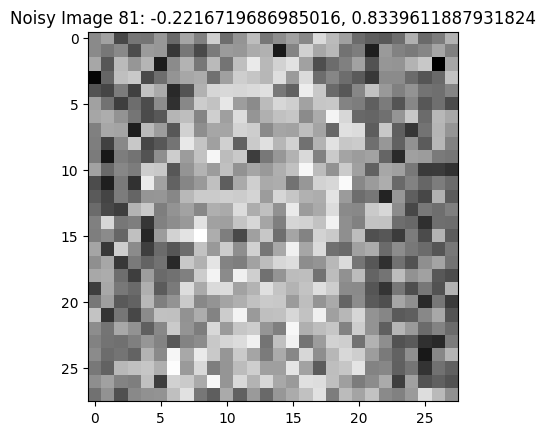

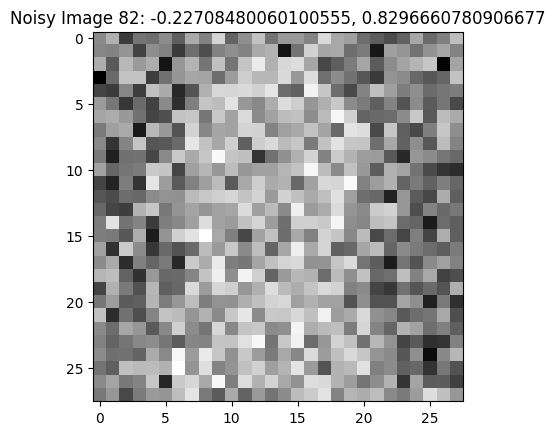

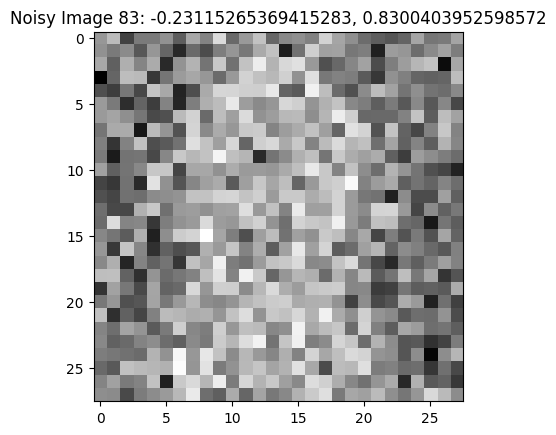

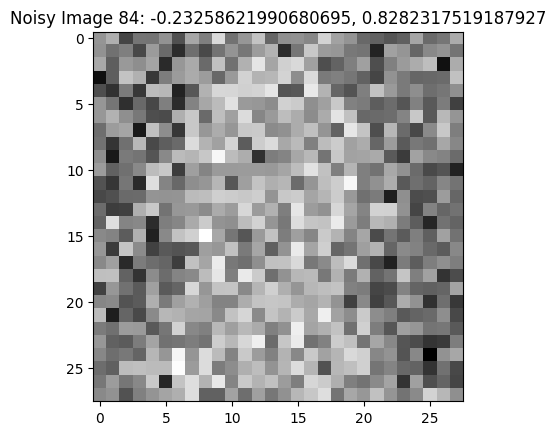

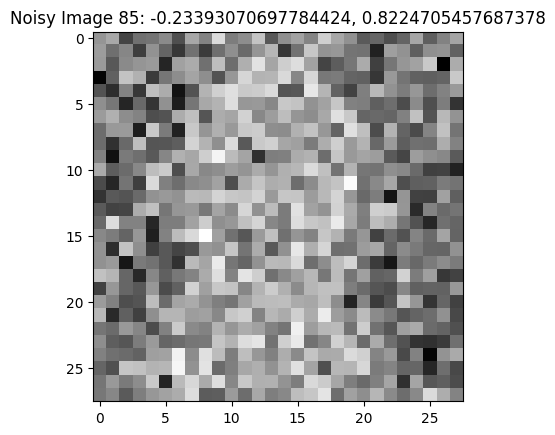

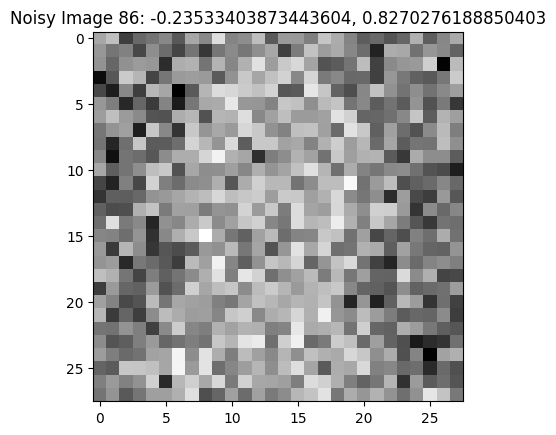

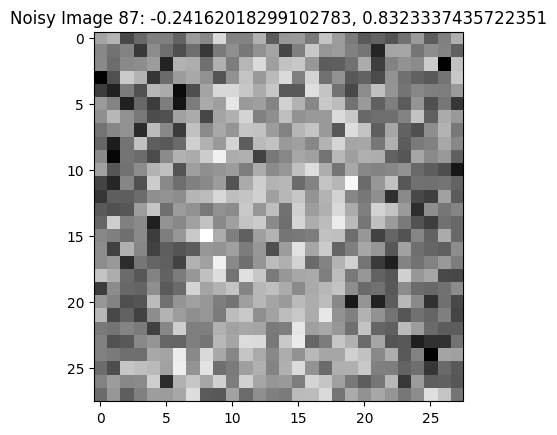

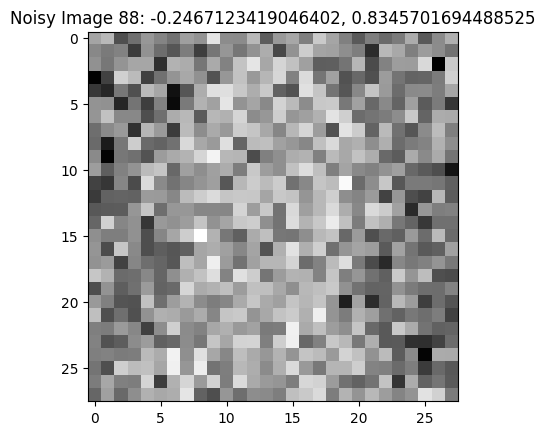

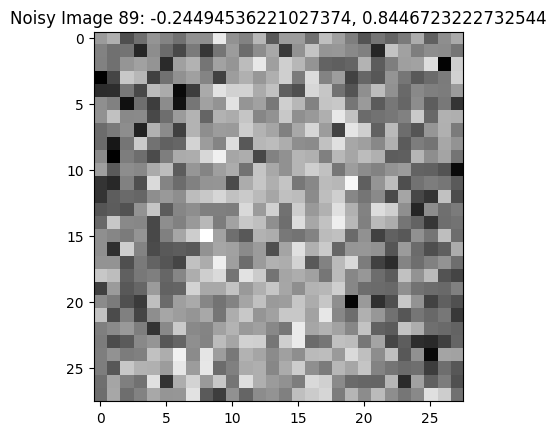

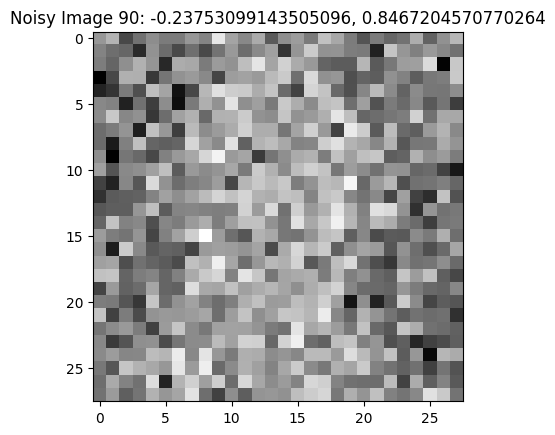

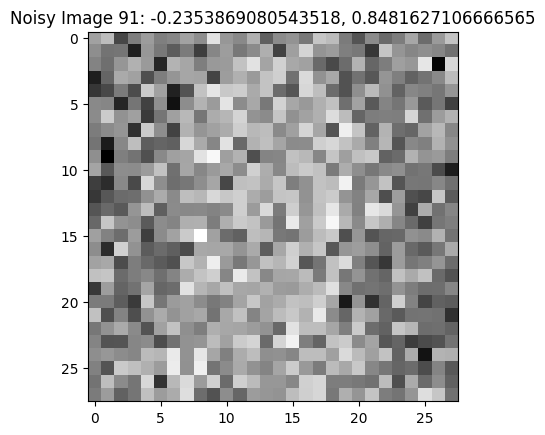

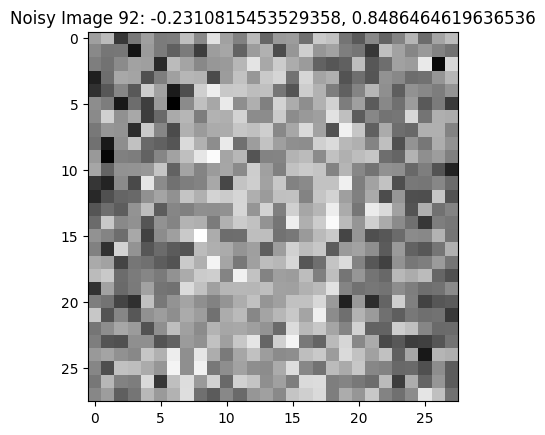

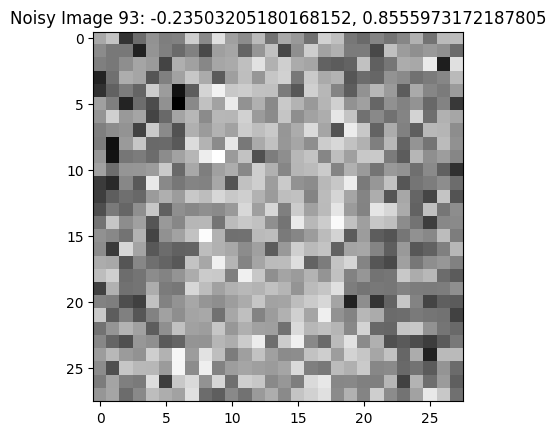

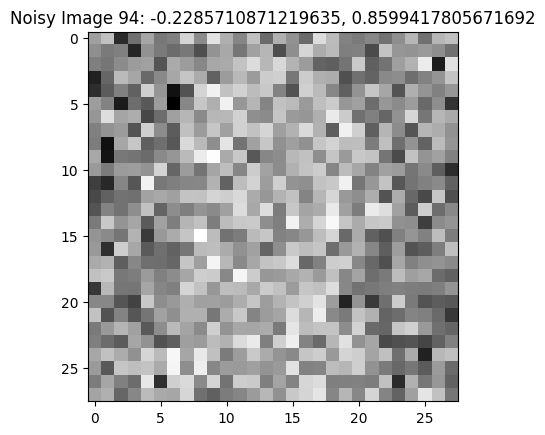

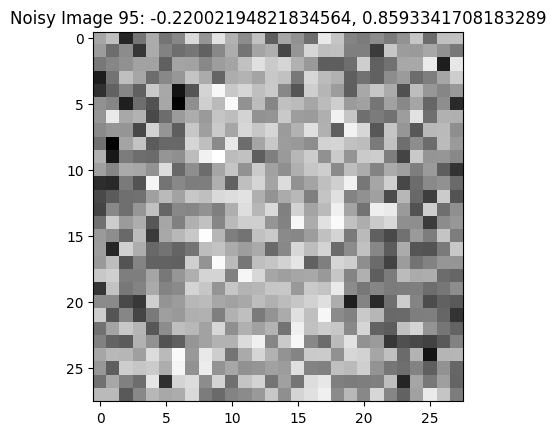

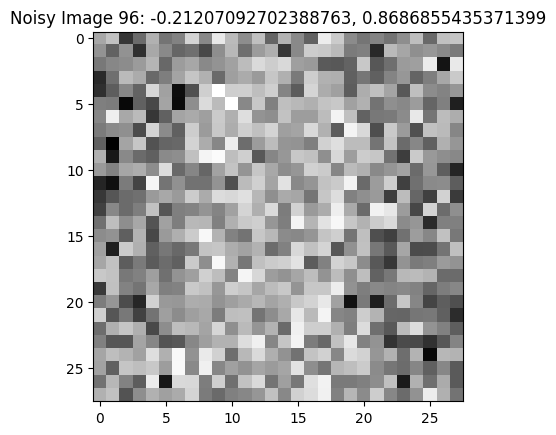

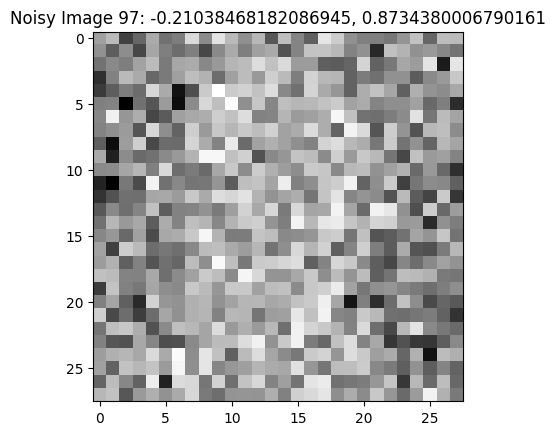

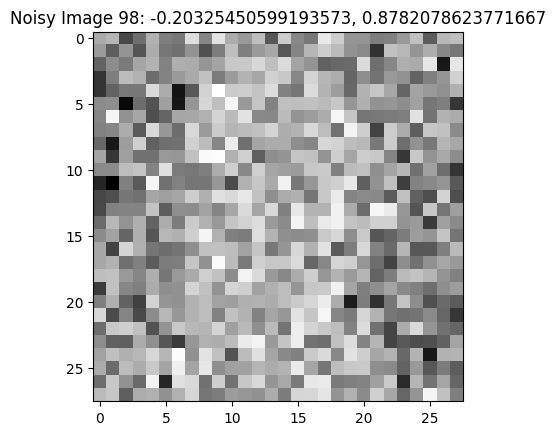

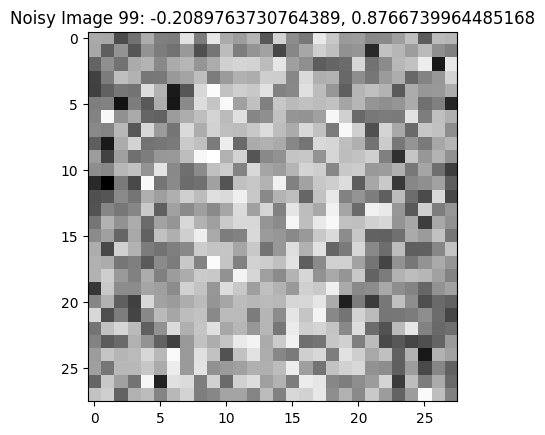

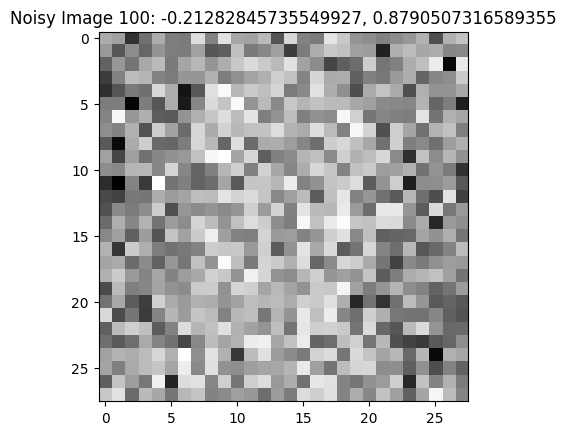

In [17]:
img_tensor = img_tensor.to(device)
mache_noise(img_tensor, 100)

In [18]:
def berechne_alpha_quer_x_forward_steps(anzahl_steps):
    scheduler = create_linear_schedule(anzahl_steps, 0.0001, 0.02)
    alphas = 1 - np.array(scheduler)
    alphas_quer = []
    for i in range(len(alphas)):
        alphas_quer.append(np.prod(alphas[:i + 1]))
    return alphas_quer

In [19]:
def x_forward_steps(curr_image, alpha_quer):
    std = np.sqrt(1 - alpha_quer) #* np.identity(like=curr_image) Nicht notwendig da äquivalent zu Skalar von Rechts
    mean = np.sqrt(alpha_quer) * curr_image
    return add_gaussian_noise(curr_image,mean=mean,std=std)

In [20]:
def mache_noise_direkt(image, anzahl_steps, total_steps):
    # Convert the image to a PyTorch tensor
    # transform = transforms.ToTensor()
    # image_tensor = transform(image)
    
    # Display the original image
    plt.imshow(image.cpu().squeeze())
    plt.title("Original Image")
    plt.show()
    
    noisy_image_tensor = image
    
    alpha_quer = berechne_alpha_quer_x_forward_steps(total_steps)
    
    noisy_image_tensor = x_forward_steps(noisy_image_tensor, alpha_quer[anzahl_steps-1])
    noisy_image = ((noisy_image_tensor/2)+0.5).cpu().squeeze()
    
    plt.imshow(noisy_image, cmap="Greys_r")
    plt.title(f"Noisy Image :{noisy_image_tensor.mean()}, {noisy_image_tensor.std()}")
    plt.show()
    


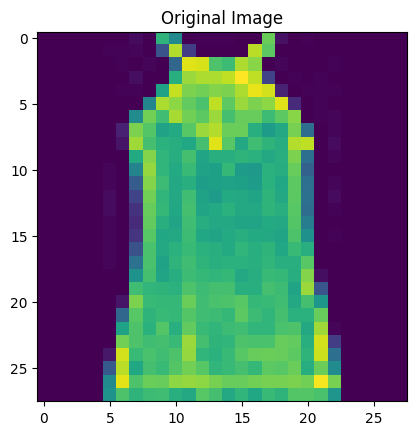

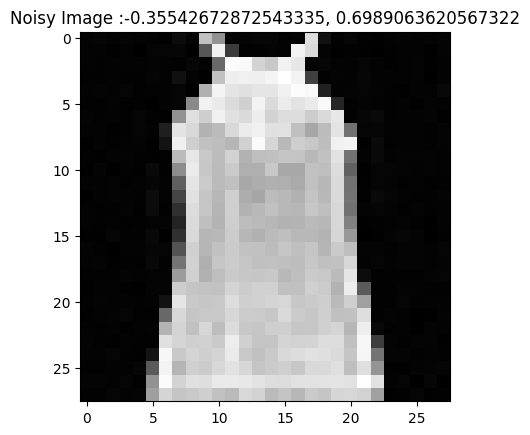

In [21]:

mache_noise_direkt(img_tensor, 1, 100)